In [20]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm,trange

import ehtim as eh
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# num visibility values, split into real/complex
INPUT_SIZE = 1030*2
INPUT_SHAPE = (1030, 2)

# n pixels in image
OUTPUT_SIZE = 28*28
OUTPUT_SHAPE = (28, 28)
to_display = eh.image.load_txt('eht-imaging/models/avery_sgra_eofn.txt');
to_display = to_display.resample_square(28)

def show_image(arr):
    """Displays image given a ndarray of pixels in shape (28,28)."""
    to_display.imvec = arr.reshape(784)
    to_display.display()

Loading text image:  eht-imaging/models/avery_sgra_eofn.txt


In [39]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.dense = nn.Sequential(
#             nn.Dropout(p=.1),
            nn.Linear(INPUT_SIZE, 56*56),
            nn.ReLU(),
        )

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU(),
            # 54 x 54
            nn.MaxPool2d(kernel_size=2, padding=1),
        )
        
        self.loss = nn.MSELoss()

    def forward(self, x):
        """
        x : shape(batch, 1030, 2)
        
        out : shape(batch, 28, 28)
        """
        x = x.flatten(start_dim=1)
        x = self.dense(x)
        
        x = x.view(-1,1,56,56)
        x = self.conv(x)
        x = x.squeeze(dim=1)
        
        return x

# Initialize model and optimizer
model = ConvNet()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [32]:
x = np.load('inputs/train_inputs_fashion_mnist_all.npy')
y = np.load('outputs/train_outputs_fashion_mnist_all.npy')
y = np.reshape(y, (len(y), 28, 28))

In [36]:
#x_amp = np.load('inputs/train_inputs_amp_and_cphase_fashion_mnist_all.npy')
print(y_test.shape)

torch.Size([16000, 28, 28])


In [33]:
x_train = torch.as_tensor(x[:44000], dtype=torch.float)
y_train = torch.as_tensor(y[:44000], dtype=torch.float)
x_test = torch.as_tensor(x[44000:], dtype=torch.float)
y_test = torch.as_tensor(y[44000:], dtype=torch.float)
trainset = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testset = torch.utils.data.TensorDataset(x_test, y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)


Target


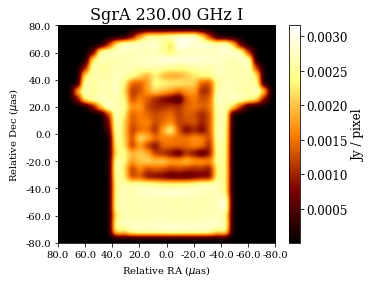

Reconstruction


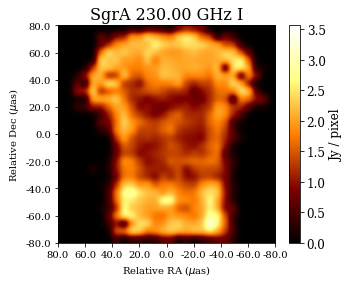

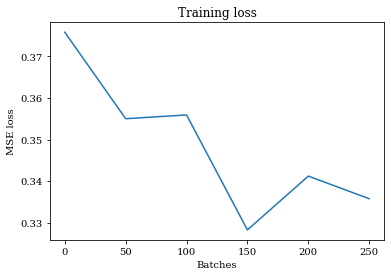


Target


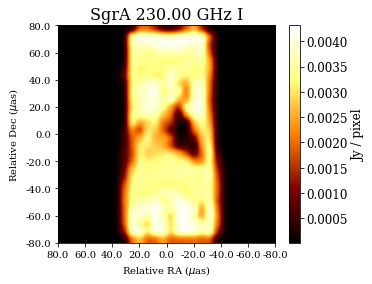

Reconstruction


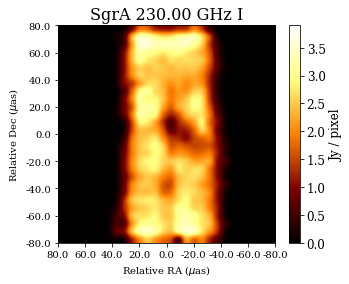

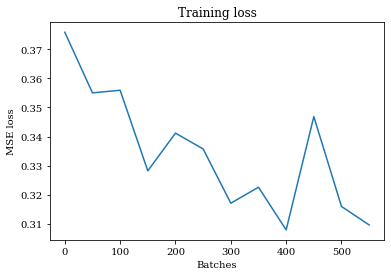


Target


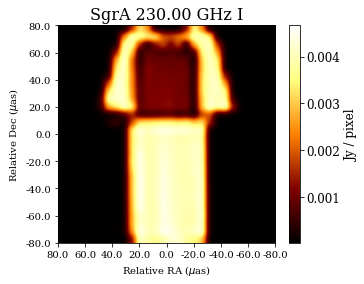

Reconstruction


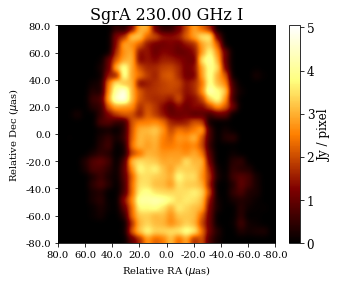

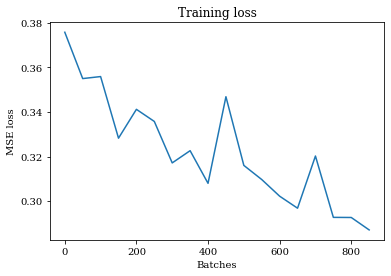


Target


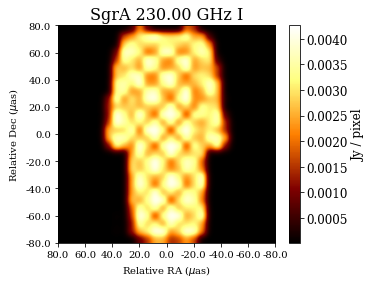

Reconstruction


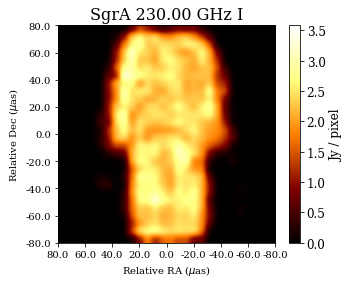

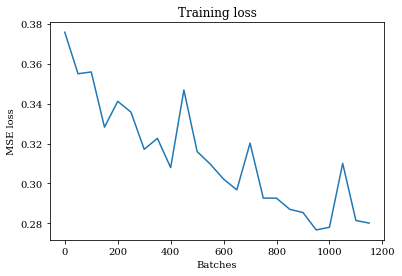


Target


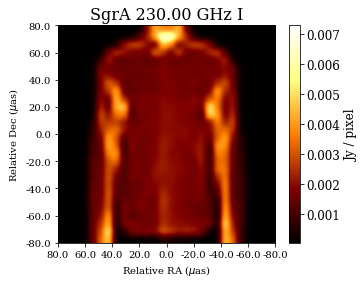

Reconstruction


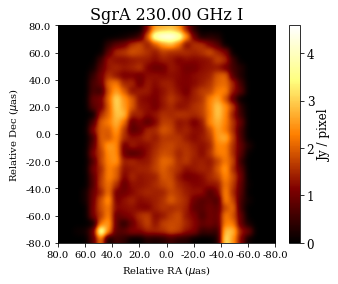

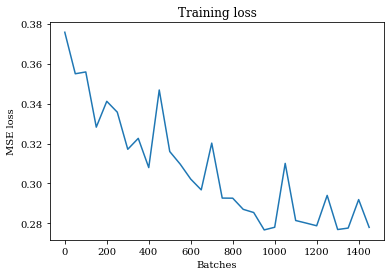


Target


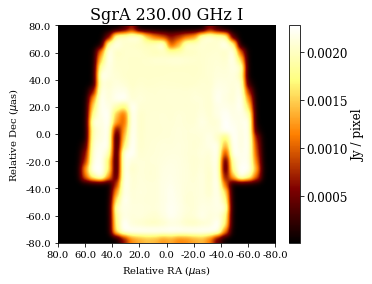

Reconstruction


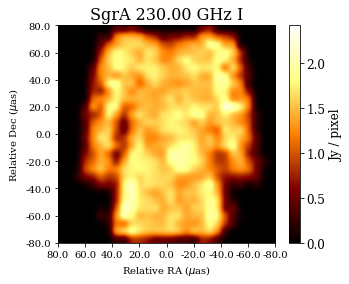

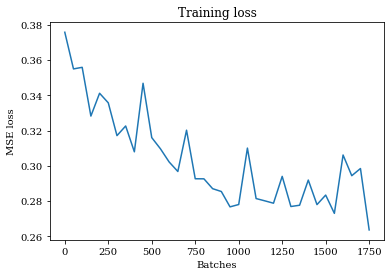


Target


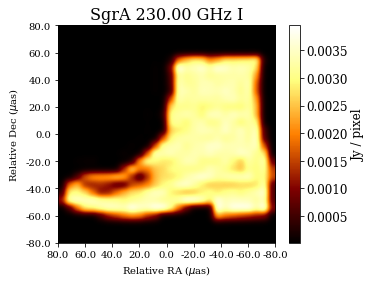

Reconstruction


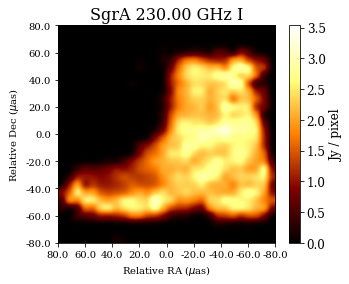

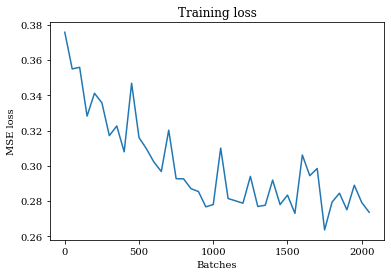


Target


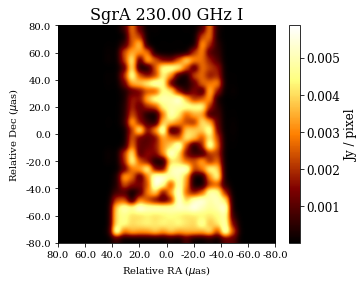

Reconstruction


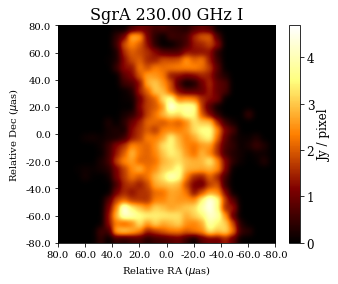

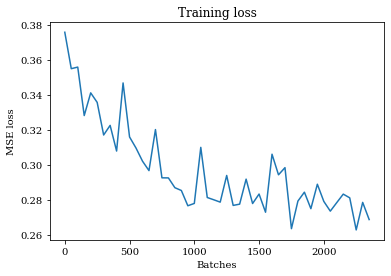


Target


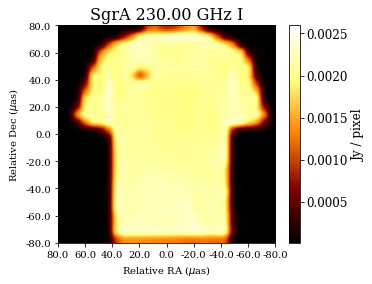

Reconstruction


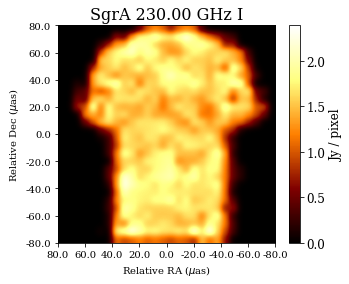

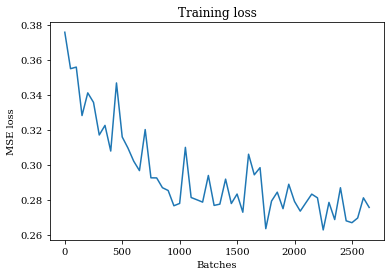


Target


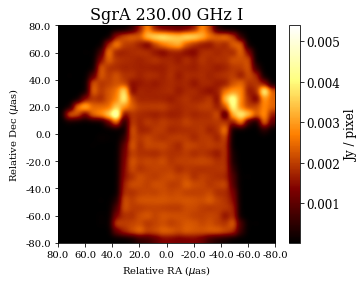

Reconstruction


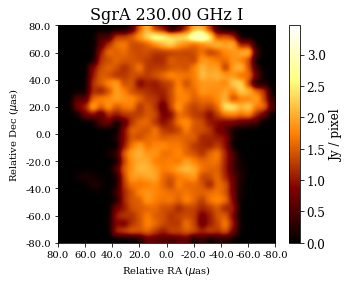

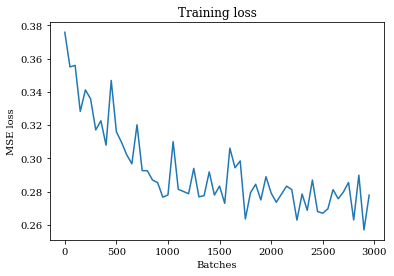

Finished Training


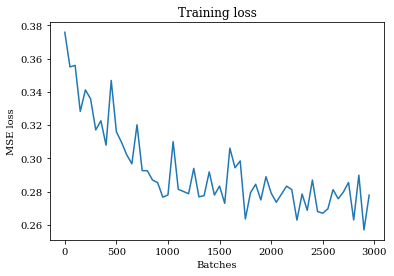

In [28]:
n_epochs = 10

# This turns on autograd so .backward() will update the model
model.train()

# Track training loss to graph later
losses = []

for epoch in range(n_epochs):

    running_loss = 0.0
    cnt = 1    # count number batches trained on
    
    # Use tqdm for pretty loading bar while training
    with tqdm(trainloader, desc='Epoch {}'.format(epoch+1)) as t:
        for data in t:
            # get the inputs and outputs; data is a list of [vis, imgs]
            # vis shape = (batch, 1030, 2)
            # imgs shape = (batch, 28, 28)
            vis, imgs = data

            #############################
            # MAIN TRAINING BLOCK START #
            #############################
        
            optimizer.zero_grad()                          # clear gradients
            outs = model(vis)                              # compute predictions for batch
            loss = model.loss(outs, OUTPUT_SIZE * imgs)    # compute loss for batch
            loss.backward()                                # backpropagate loss
            optimizer.step()                               # perform gradient updates
            
            ###########################
            # MAIN TRAINING BLOCK END #
            ###########################

            # print statistics and progress
            running_loss += loss.item()    # scalar
            
            # update loss in loading bar every 5 mini-batches
            if cnt % 5 == 0:    
                if cnt % 50 == 0:
                    losses.append(running_loss / 5)    # plot on graph
                    
                t.set_postfix(loss=running_loss / 5)
                running_loss = 0.0
            
            cnt += 1
            
    # Show example image for current progress
    print('Target')
    show_image(imgs[-1].detach().numpy())
    print('Reconstruction')
    show_image(outs[-1].detach().numpy())
    
    # Visualize training loss curve
    fig, ax = plt.subplots()
    ax.plot(list(range(0, len(losses)*50, 50)), losses)
    ax.set(xlabel='Batches', ylabel='MSE loss', title='Training loss')
    plt.show()
            

print('Finished Training')

# Visualize training loss curve
fig, ax = plt.subplots()
ax.plot(list(range(0, len(losses)*50, 50)), losses)
ax.set(xlabel='Batches', ylabel='MSE loss', title='Training loss')
plt.show()

In [40]:
model.load_state_dict(torch.load("models/1dense1convpool/noisy_1dense1convpool_20kimg_10ep.pickle"))

<All keys matched successfully>

Target


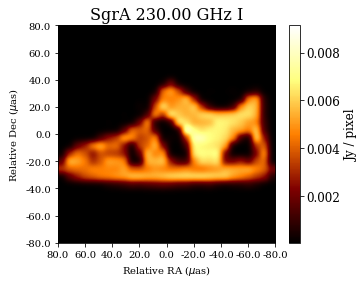

Reconstruction


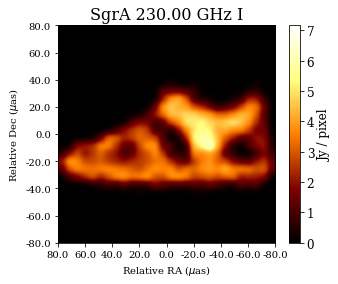

Target


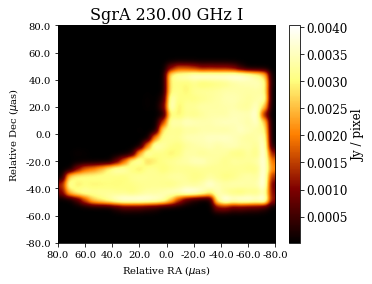

Reconstruction


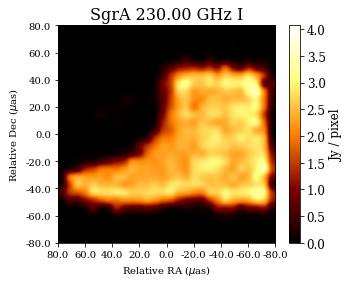

Target


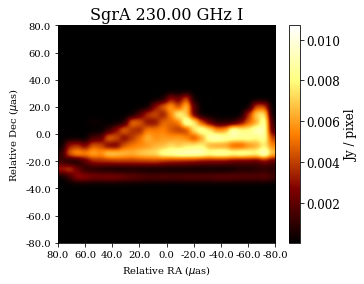

Reconstruction


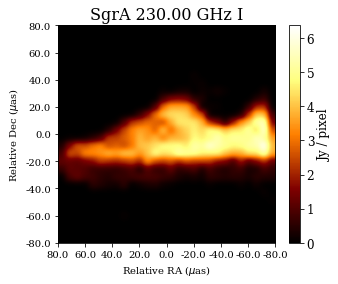

Target


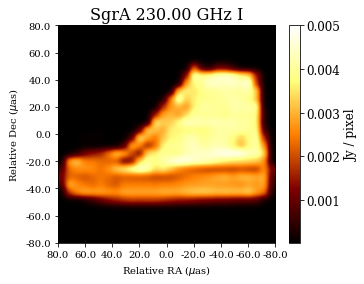

Reconstruction


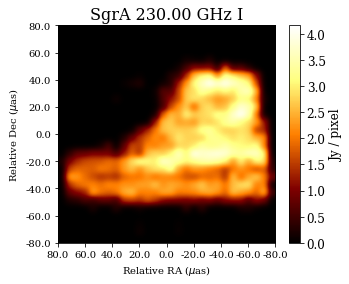

Target


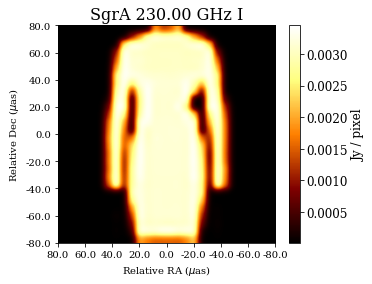

Reconstruction


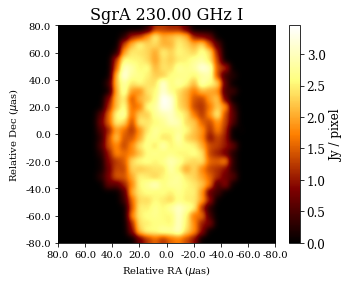

Target


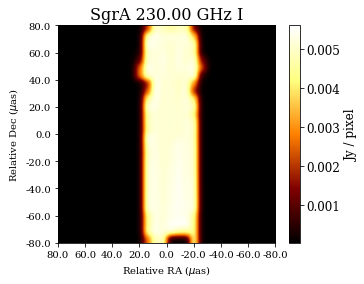

Reconstruction


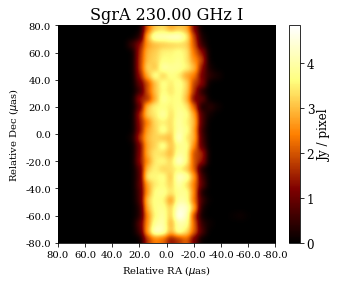

Target


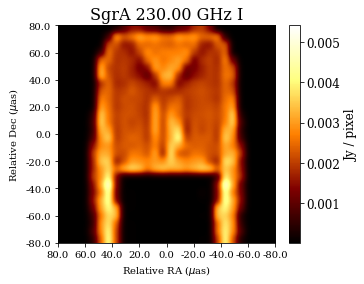

Reconstruction


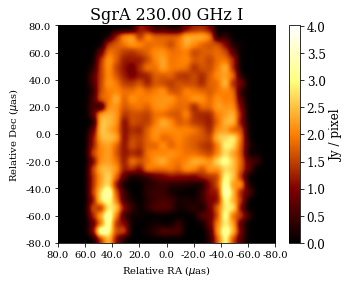

Target


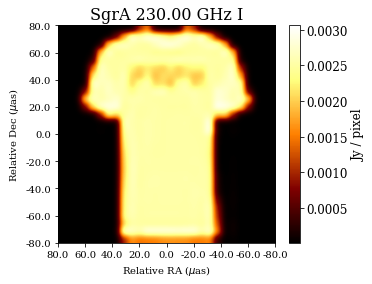

Reconstruction


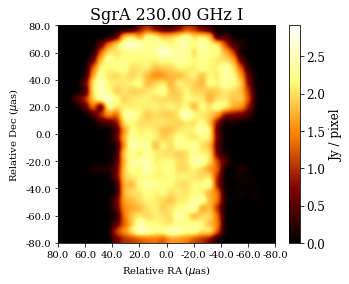

Target


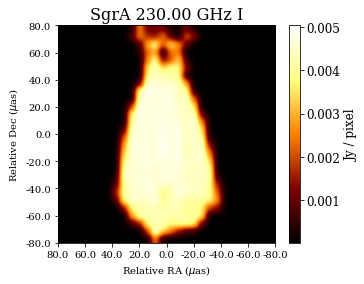

Reconstruction


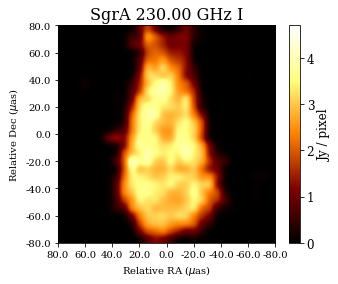

Target


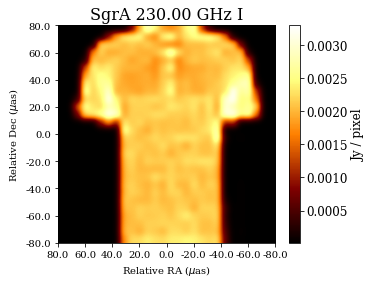

Reconstruction


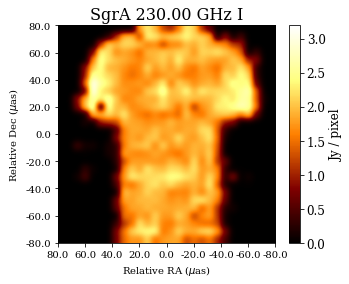

Target


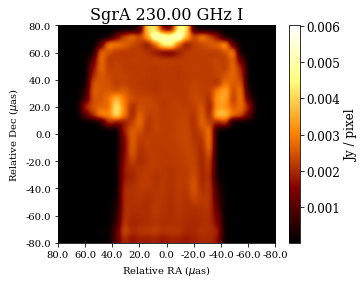

Reconstruction


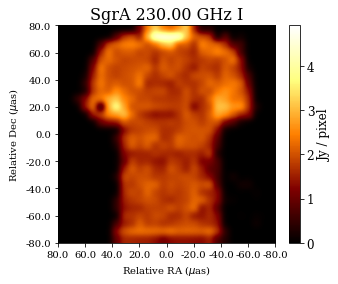

Target


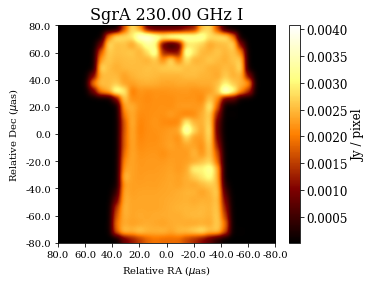

Reconstruction


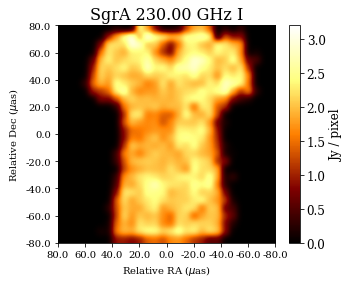

Target


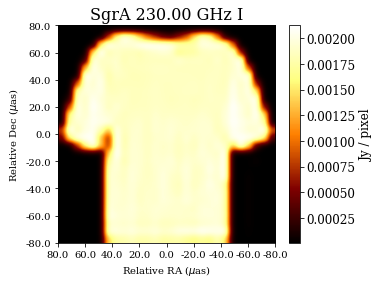

Reconstruction


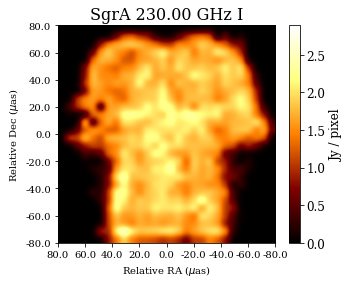

Target


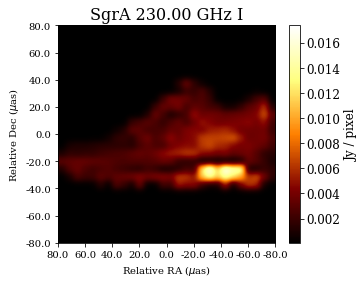

Reconstruction


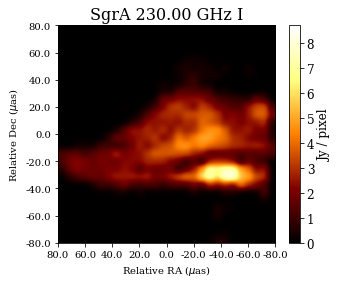

Target


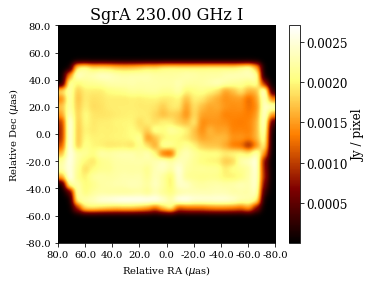

Reconstruction


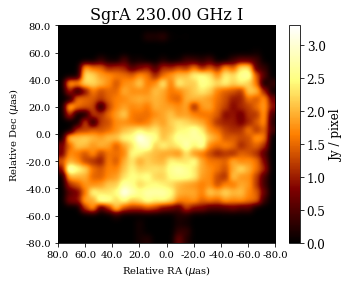

Target


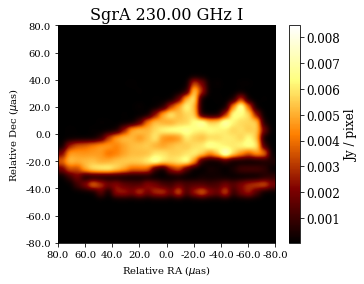

Reconstruction


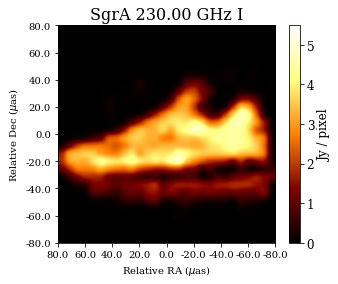


average loss:  0.3241193645735207


In [42]:
# Prevent torch from saving gradients so it evaluates faster
with torch.no_grad():
    tot_loss = 0
    cnt = 1
    for data in tqdm(testloader):
        # get the inputs, outputs
        # see training block for shape desc.
        vis, imgs = data

        # scale vis up so avg pixel is 1
        vis = INPUT_SIZE * vis
        
        # Generate image and sum up loss
        outs = model(vis)
        tot_loss += model.loss(outs, OUTPUT_SIZE * imgs).item()
        
        if cnt >= 100 and cnt % 1000 == 0:
            print('Target')
            show_image(imgs[0].numpy())
            print('Reconstruction')
            show_image(outs[0].numpy())
        
        cnt += 1
    
print("average loss: ", tot_loss/cnt)